In [2]:
import os
import json
import shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import descartes
from nuscenes import NuScenes, NuScenesExplorer
from nuscenes.map_expansion.map_api import NuScenesMap, NuScenesMapExplorer
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap
from nuscenes.utils.geometry_utils import view_points
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from shapely.geometry import Polygon, MultiPolygon, LineString, Point, box
from pyquaternion import Quaternion
from torch.utils.data import Dataset

In [3]:
dataroot = '../../../Datasets/nuscenes/mini'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot)
#nusc.list_scenes()

scene = nusc.scene[2]
sample_token = scene['first_sample_token']
for i in range(33):
    sample_token = nusc.get('sample', sample_token)['next']
sample_record = nusc.get('sample', sample_token)
scene_record = nusc.get('scene', sample_record['scene_token'])
log_record = nusc.get('log', scene_record['log_token'])
log_location = log_record['location']

lidar_token = sample_record['data']['LIDAR_TOP']
camera_token = sample_record['data']['CAM_FRONT']

cam = nusc.get('sample_data', camera_token)
cam_w = cam['width']
cam_h = cam['height']

camera_calibration_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])

# Load the map for the location
nusc_map = NuScenesMap(dataroot=dataroot, map_name=log_location)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.371 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## Render BEV

/home/txw190000/Workspace/UncertaintyBEVMapping/venv_39/lib/python3.9/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/txw190000/Workspace/UncertaintyBEVMapping/venv_39/lib/python3.9/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]
/tmp/ipykernel_1883299/215987862.py:313: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  cv2.fillPoly(objects_img, pts=[np.int0(track_box)], color=(255, 255, 

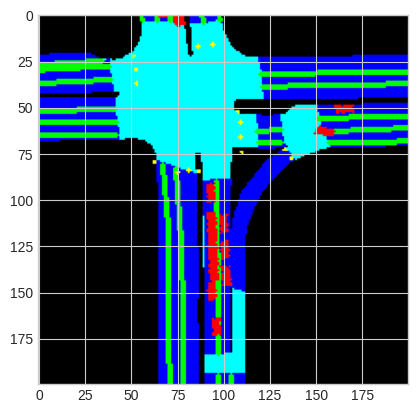

In [4]:
# Render BEV

import cv2
from typing import Dict, List, Tuple, Any
from nuscenes.prediction.input_representation.utils import convert_to_pixel_coords
from typing import List, Dict, Tuple
from shapely.geometry import Polygon, MultiPolygon, LineString, Point, box
from pyquaternion import Quaternion
from shapely import affinity

def correct_yaw(yaw: float) -> float:
    """
    nuScenes maps were flipped over the y-axis, so we need to
    add pi to the angle needed to rotate the heading.
    :param yaw: Yaw angle to rotate the image.
    :return: Yaw after correction.
    """
    if yaw <= 0:
        yaw = -np.pi - yaw
    else:
        yaw = np.pi - yaw

    return yaw

def angle_of_rotation(yaw: float) -> float:
    """
    Given a yaw angle (measured from x axis), find the angle needed to rotate by so that
    the yaw is aligned with the y axis (pi / 2).
    :param yaw: Radians. Output of quaternion_yaw function.
    :return: Angle in radians.
    """
    return (np.pi / 2) + np.sign(-yaw) * np.abs(yaw)

def quaternion_yaw(q: Quaternion) -> float:
    """
    Calculate the yaw angle from a quaternion.
    Note that this only works for a quaternion that represents a box in lidar or global coordinate frame.
    It does not work for a box in the camera frame.
    :param q: Quaternion of interest.
    :return: Yaw angle in radians.
    """

    # Project into xy plane.
    v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))

    # Measure yaw using arctan.
    yaw = np.arctan2(v[1], v[0])

    return yaw

def pixels_to_box_corners(row_pixel: int,
                          column_pixel: int,
                          length_in_pixels: float,
                          width_in_pixels: float,
                          yaw_in_radians: float) -> np.ndarray:
    """
    Computes four corners of 2d bounding box for agent.
    The coordinates of the box are in pixels.
    :param row_pixel: Row pixel of the agent.
    :param column_pixel: Column pixel of the agent.
    :param length_in_pixels: Length of the agent.
    :param width_in_pixels: Width of the agent.
    :param yaw_in_radians: Yaw of the agent (global coordinates).
    :return: numpy array representing the four corners of the agent.
    """

    # cv2 has the convention where they flip rows and columns so it matches
    # the convention of x and y on a coordinate plane
    # Also, a positive angle is a clockwise rotation as opposed to counterclockwise
    # so that is why we negate the rotation angle
    coord_tuple = ((column_pixel, row_pixel), (length_in_pixels, width_in_pixels), -yaw_in_radians * 180 / np.pi)

    box = cv2.boxPoints(coord_tuple)

    return box

def get_track_box(annotation: Dict[str, Any],
                  center_coordinates: Tuple[float, float],
                  center_pixels: Tuple[float, float],
                  resolution: float = 0.1) -> np.ndarray:
    """
    Get four corners of bounding box for agent in pixels.
    :param annotation: The annotation record of the agent.
    :param center_coordinates: (x, y) coordinates in global frame
        of the center of the image.
    :param center_pixels: (row_index, column_index) location of the center
        of the image in pixel coordinates.
    :param resolution: Resolution pixels/meter of the image.
    """

    assert resolution > 0

    location = annotation['translation'][:2]
    yaw_in_radians = quaternion_yaw(Quaternion(annotation['rotation']))

    row_pixel, column_pixel = convert_to_pixel_coords(location,
                                                      center_coordinates,
                                                      center_pixels, resolution)

    width = annotation['size'][0] / resolution
    length = annotation['size'][1] / resolution

    # Width and length are switched here so that we can draw them along the x-axis as
    # opposed to the y. This makes rotation easier.
    return pixels_to_box_corners(row_pixel, column_pixel, length, width, yaw_in_radians)


def get_rotation_matrix(image_shape: Tuple[int, int, int], yaw_in_radians: float) -> np.ndarray:
    """
    Gets a rotation matrix to rotate a three channel image so that
    yaw_in_radians points along the positive y-axis.
    :param image_shape: (Length, width, n_channels).
    :param yaw_in_radians: Angle to rotate the image by.
    :return: rotation matrix represented as np.ndarray.
    :return: The rotation matrix.
    """

    rotation_in_degrees = angle_of_rotation(yaw_in_radians) * 180 / np.pi

    return cv2.getRotationMatrix2D((image_shape[1] / 2, image_shape[0] / 2), rotation_in_degrees, 1)

# Utility functions from nuScenes

def _is_polygon_record_in_patch(map_api,
                                token: str,
                                layer_name: str,
                                box_coords: Tuple[float, float, float, float],
                                mode: str = 'intersect') -> bool:
    """
    Query whether a particular polygon record is in a rectangular patch.
    :param layer_name: The layer name of the record.
    :param token: The record token.
    :param box_coords: The rectangular patch coordinates (x_min, y_min, x_max, y_max).
    :param mode: "intersect" means it will return True if the geometric object intersects the patch and False
    otherwise, "within" will return True if the geometric object is within the patch and False otherwise.
    :return: Boolean value on whether a particular polygon record intersects or is within a particular patch.
    """
    if layer_name not in map_api.lookup_polygon_layers:
        raise ValueError('{} is not a polygonal layer'.format(layer_name))

    x_min, y_min, x_max, y_max = box_coords
    record = map_api.get(layer_name, token)
    rectangular_patch = box(x_min, y_min, x_max, y_max)

    if layer_name == 'drivable_area':
        polygons = [map_api.extract_polygon(polygon_token) for polygon_token in record['polygon_tokens']]
        geom = MultiPolygon(polygons)
    else:
        geom = map_api.extract_polygon(record['polygon_token'])

    if mode == 'intersect':
        return geom.intersects(rectangular_patch)
    elif mode == 'within':
        return geom.within(rectangular_patch)

def _is_line_record_in_patch(map_api,
                                token: str,
                                layer_name: str,
                                box_coords: Tuple[float, float, float, float],
                                mode: str = 'intersect') -> bool:
    """
    Query whether a particular line record is in a rectangular patch.
    :param layer_name: The layer name of the record.
    :param token: The record token.
    :param box_coords: The rectangular patch coordinates (x_min, y_min, x_max, y_max).
    :param mode: "intersect" means it will return True if the geometric object intersects the patch and False
    otherwise, "within" will return True if the geometric object is within the patch and False otherwise.
    :return: Boolean value on whether a particular line  record intersects or is within a particular patch.
    """
    if layer_name not in map_api.non_geometric_line_layers:
        raise ValueError("{} is not a line layer".format(layer_name))

    # Retrieve nodes of this line.
    record = map_api.get(layer_name, token)
    node_recs = [map_api.get('node', node_token) for node_token in record['node_tokens']]
    node_coords = [[node['x'], node['y']] for node in node_recs]
    node_coords = np.array(node_coords)

    # A few lines in Queenstown have zero nodes. In this case we return False.
    if len(node_coords) == 0:
        return False

    # Check that nodes fall inside the path.
    x_min, y_min, x_max, y_max = box_coords
    cond_x = np.logical_and(node_coords[:, 0] < x_max, node_coords[:, 0] > x_min)
    cond_y = np.logical_and(node_coords[:, 1] < y_max, node_coords[:, 1] > y_min)
    cond = np.logical_and(cond_x, cond_y)
    if mode == 'intersect':
        return np.any(cond)
    elif mode == 'within':
        return np.all(cond)

def is_record_in_patch(
    map_api,
    layer_name: str,
    token: str,
    box_coords: Tuple[float, float, float, float],
    mode: str = 'intersect') -> bool:
    """
    Query whether a particular record is in a rectangular patch.
    :param layer_name: The layer name of the record.
    :param token: The record token.
    :param box_coords: The rectangular patch coordinates (x_min, y_min, x_max, y_max).
    :param mode: "intersect" means it will return True if the geometric object intersects the patch and False
    otherwise, "within" will return True if the geometric object is within the patch and False otherwise.
    :return: Boolean value on whether a particular record intersects or is within a particular patch.
    """
    if mode not in ['intersect', 'within']:
        raise ValueError("Mode {} is not valid, choice=('intersect', 'within')".format(mode))

    if layer_name in map_api.lookup_polygon_layers:
        return _is_polygon_record_in_patch(map_api, token, layer_name, box_coords, mode)
    elif layer_name in  map_api.non_geometric_line_layers:
        return _is_line_record_in_patch(map_api, token, layer_name, box_coords,  mode)
    else:
        raise ValueError("{} is not a valid layer".format(layer_name))

def get_records_in_patch(
    map_api,
    box_coords: Tuple[float, float, float, float],
    layer_names: List[str] = None,
    mode: str = 'intersect') -> Dict[str, List[str]]:
    """
    Get all the record token that intersects or within a particular rectangular patch.
    :param box_coords: The rectangular patch coordinates (x_min, y_min, x_max, y_max).
    :param layer_names: Names of the layers that we want to retrieve in a particular patch.
        By default will always look for all non geometric layers.
    :param mode: "intersect" will return all non geometric records that intersects the patch,
        "within" will return all non geometric records that are within the patch.
    :return: Dictionary of layer_name - tokens pairs.
    """
    if mode not in ['intersect', 'within']:
        raise ValueError("Mode {} is not valid, choice=('intersect', 'within')".format(mode))

    records_in_patch = dict()
    for layer_name in layer_names:
        layer_records = []
        for record in getattr(map_api, layer_name):
            token = record['token']
            if is_record_in_patch(map_api, layer_name, token, box_coords, mode):
                layer_records.append(token)

        records_in_patch.update({layer_name: layer_records})

    return records_in_patch

def render_bev(nusc, nusc_map, sample_token):
    bev_size = np.array([100, 100]) # 100m x 100m centered by the ego vehicle
    image_size = np.array([200, 200]) # bev image resolution

    #sample_token = scene['first_sample_token']
    sample_record = nusc.get('sample', sample_token)
    scene_record = nusc.get('scene', sample_record['scene_token'])
    log_record = nusc.get('log', scene_record['log_token'])
    log_location = log_record['location'] # City name

    lidar_token = sample_record['data']['LIDAR_TOP']
    lidar_record = nusc.get('sample_data', lidar_token)

    ego_pose_token = nusc.get('sample_data', sample_record['data']['LIDAR_TOP'])['ego_pose_token']
    ego_pose_record = nusc.get('ego_pose', ego_pose_token)
    ego_location = ego_pose_record['translation']

    patch_radius = 50
    box_coords = [
        ego_location[0] - patch_radius,
        ego_location[1] - patch_radius,
        ego_location[0] + patch_radius,
        ego_location[1] + patch_radius,
    ]

    records_in_patch = get_records_in_patch(nusc_map, box_coords, ['drivable_area', 'traffic_light'], 'intersect')

    # Plot the bev
    scale = bev_size[0] / image_size[0] # scale ratio

    img = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    patch_box = (ego_location[0], ego_location[1], bev_size[0], bev_size[1])

    ego_yaw = Quaternion(ego_pose_record['rotation']).yaw_pitch_roll[0]
    yaw_corrected = correct_yaw(ego_yaw)
    angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi

    patch_angle = angle_in_degrees  # Default orientation where North is up

    layer_names = ['drivable_area', 'road_block', 'lane_divider', 'road_divider']

    map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, image_size).astype(bool)
    # shape of map_mask: (layer, y, x).
    # Coordinate of map_mask is based on the map image, so (x, y) in nuscene coordinate becomes (-y, x).
    # We'll need to convert the coordinate back.
    map_mask = map_mask[:, ::-1, :]

    img[map_mask[0]] = [0, 255, 255]
    img[map_mask[1]] = [0, 0, 255]
    img[map_mask[2]] = [0, 255, 0]
    img[map_mask[3]] = [0, 255, 0]
    
    objects_img = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    for token in records_in_patch['traffic_light']:
        record = nusc_map.get('traffic_light', token)
        coord = np.array([record['pose']['tx'], record['pose']['ty'], record['pose']['tz']])
        bev_coord =  coord - np.array(ego_pose_record['translation'])
        #bev_coord = np.dot(Quaternion(ego_pose_record['rotation']).rotation_matrix.T, bev_coord)
        annotation = {
            'translation': coord,
            'rotation': Quaternion(),
            'size': [0.5, 0.5, 1.0],
        }
        track_box = get_track_box(annotation, (ego_location[0], ego_location[1]), image_size/2, scale)
        cv2.fillPoly(objects_img, pts=[np.int0(track_box)], color=(255, 255, 0))
    
    vehicle_bboxes = []

    for annotation_token in sample_record['anns']:
        annotation_record = nusc.get('sample_annotation', annotation_token)
        instance_record = nusc.get('instance', annotation_record['instance_token'])
        category_name = annotation_record['category_name']
        if category_name.startswith('vehicle'):

            track_box = get_track_box(annotation_record, (ego_location[0], ego_location[1]), image_size/2, scale)
            cv2.fillPoly(objects_img, pts=[np.int0(track_box)], color=(255, 0, 0))
    
    center_agent_yaw = quaternion_yaw(Quaternion(ego_pose_record['rotation']))
    rotation_mat = get_rotation_matrix(image_size, center_agent_yaw)
    objects_img = cv2.warpAffine(objects_img, rotation_mat, (image_size[1], image_size[0]), flags=cv2.INTER_NEAREST)
    #plt.imshow(objects_img)

    # render objects on top of map
    mask = np.repeat(np.expand_dims((objects_img != 0).any(-1), -1), 3, axis = 2)
    np.putmask(img, mask, objects_img)

    return img

bev_image = render_bev(nusc, nusc_map, sample_token)
plt.imshow(bev_image)

## BEV mapping

(34752, 4)


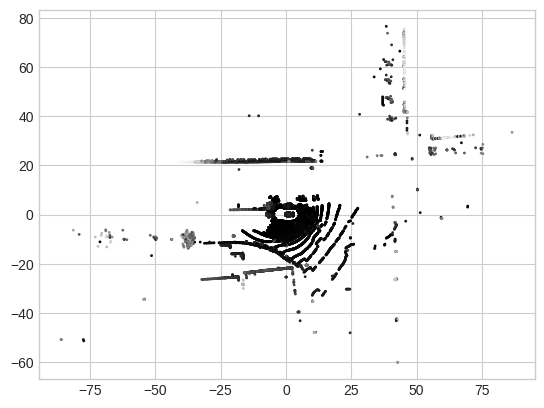

<Figure size 640x480 with 0 Axes>

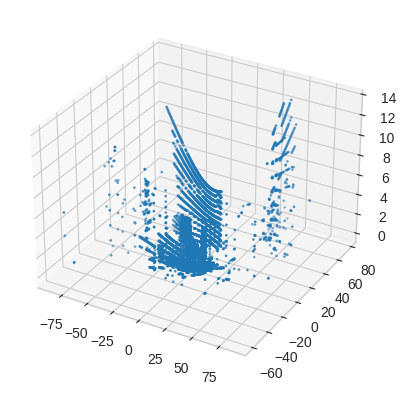

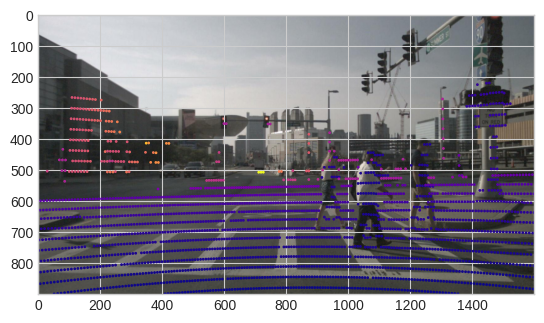

(900, 1600)
0.0
99.02183737841688


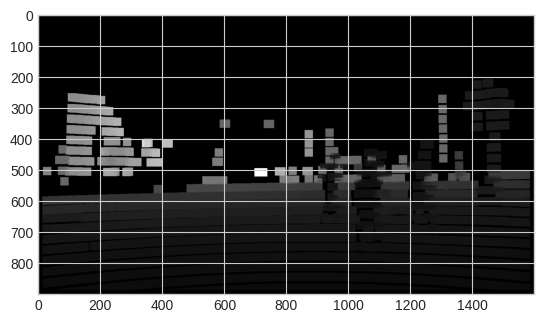

In [5]:
# depth estimation

import cv2
from nuscenes.utils.data_classes import LidarPointCloud, RadarPointCloud, Box
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix
from PIL import Image
import matplotlib.image as mpimg


def get_view_matrix(h=200, w=200, h_meters=100.0, w_meters=100.0, offset=0.0):
    sh = h / h_meters
    sw = w / w_meters

    return np.float32([
        [ 0., -sw,          w/2.],
        [-sh,  0., h*offset+h/2.],
        [ 0.,  0.,            1.]
    ])

def get_transformation_matrix(R, t, inv=False):
    pose = np.eye(4, dtype=np.float32)
    pose[:3, :3] = R if not inv else R.T
    pose[:3, -1] = t if not inv else R.T @ -t

    return pose

def get_pose(rotation, translation, inv=False, flat=False):
    if flat:
        yaw = Quaternion(rotation).yaw_pitch_roll[0]
        R = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).rotation_matrix
    else:
        R = Quaternion(rotation).rotation_matrix

    t = np.array(translation, dtype=np.float32)

    return get_transformation_matrix(R, t, inv=inv)

# From https://github.com/BerensRWU/DenseMap/blob/main/depth_map.py
def dense_map(Pts, n, m, grid):
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + float("inf")
    mY = np.zeros((m,n)) + float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out

def get_depth(nusc, sample, camera='CAM_FRONT'):
    lidar_token = sample['data']['LIDAR_TOP']
    camera_token = sample['data'][camera]

    cam = nusc.get('sample_data', camera_token)
    cam_w = cam['width']
    cam_h = cam['height']

    lidar = nusc.get('sample_data', lidar_token)

    pcl_path = os.path.join(nusc.dataroot, lidar['filename'])
    img_path = os.path.join(nusc.dataroot, cam['filename'])
    lidar_points = LidarPointCloud.from_file(pcl_path)

    # # Points live in the lidar sensor frame.
    # # First step: transform the pointcloud to the ego vehicle frame for the timestamp of the sweep.
    cs_record = nusc.get('calibrated_sensor', lidar['calibrated_sensor_token'])
    lidar_points.rotate(Quaternion(cs_record['rotation']).rotation_matrix)
    lidar_points.translate(np.array(cs_record['translation']))

    # # Second step: transform from ego to the global frame.
    # poserecord = nusc.get('ego_pose', lidar['ego_pose_token'])
    # lidar_points.rotate(Quaternion(poserecord['rotation']).rotation_matrix)
    # lidar_points.translate(np.array(poserecord['translation']))

    # # Third step: transform from global into the ego vehicle frame for the timestamp of the image.
    # poserecord = nusc.get('ego_pose', cam['ego_pose_token'])
    # lidar_points.translate(-np.array(poserecord['translation']))
    # lidar_points.rotate(Quaternion(poserecord['rotation']).rotation_matrix.T)

    points = lidar_points.points.T

    print(points.shape)

    points = np.array([point for point in points if point[2] > 0.0 ])
    plt.clf()
    plt.scatter(points[:, 0], points[:, 1], s=1.0, c=-points[:, 2])
    plt.show()

    plt.clf()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1.0)
    plt.show()

    # Fourth step: transform from ego into the camera.
    cs_record = nusc.get('calibrated_sensor', cam['calibrated_sensor_token'])
    lidar_points.translate(-np.array(cs_record['translation']))
    lidar_points.rotate(Quaternion(cs_record['rotation']).rotation_matrix.T)
    
    depths = lidar_points.points[2, :]
    points = view_points(lidar_points.points[:3, :], np.array(cs_record['camera_intrinsic']), normalize=True)
    mask = np.ones(depths.shape[0], dtype=bool)
    mask = np.logical_and(mask, depths > 1.0)
    mask = np.logical_and(mask, points[0, :] > 1)
    mask = np.logical_and(mask, points[0, :] < cam_w - 1)
    mask = np.logical_and(mask, points[1, :] > 1)
    mask = np.logical_and(mask, points[1, :] < cam_h - 1)
    points = points[:, mask].T
    depths = depths[mask]

    plt.clf()
    plt.scatter(points[:, 0], points[:, 1], s=1.0, cmap='plasma', c=depths)
    plt.imshow(mpimg.imread(img_path))
    plt.show()

    points[:, 2] = depths

    depth_gt = dense_map(points.T, cam_w, cam_h, 13)

    return depth_gt

depth_gt = get_depth(nusc, sample_record)
print(depth_gt.shape)
print(depth_gt.min())
print(depth_gt.max())
plt.imshow(depth_gt, cmap='gray')
plt.show()